In [ ]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# 📁 2. Load Data
#df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

#print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Train shape: {df_sample.shape}")

Train shape: (8921483, 83)
Test shape: (7853253, 82)


In [29]:
# 📁 2. Load Data
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')


print(f"Test shape: {df_test.shape}")
print(f"Train shape: {df_sample.shape}")

Test shape: (7853253, 82)
Train shape: (7853253, 2)


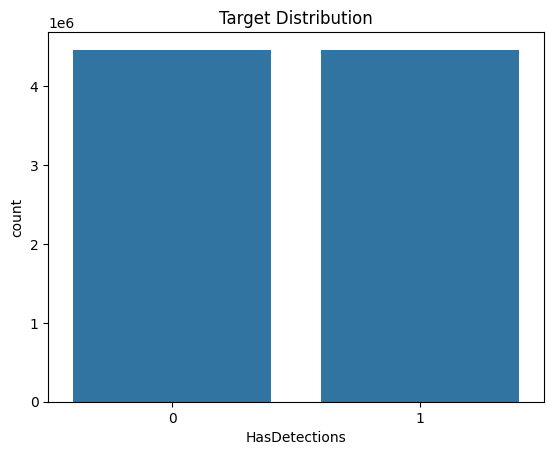

In [4]:
# 🎯 3. Target Variable Distribution
sns.countplot(data=df_train, x='HasDetections')
plt.title('Target Distribution')
plt.show()

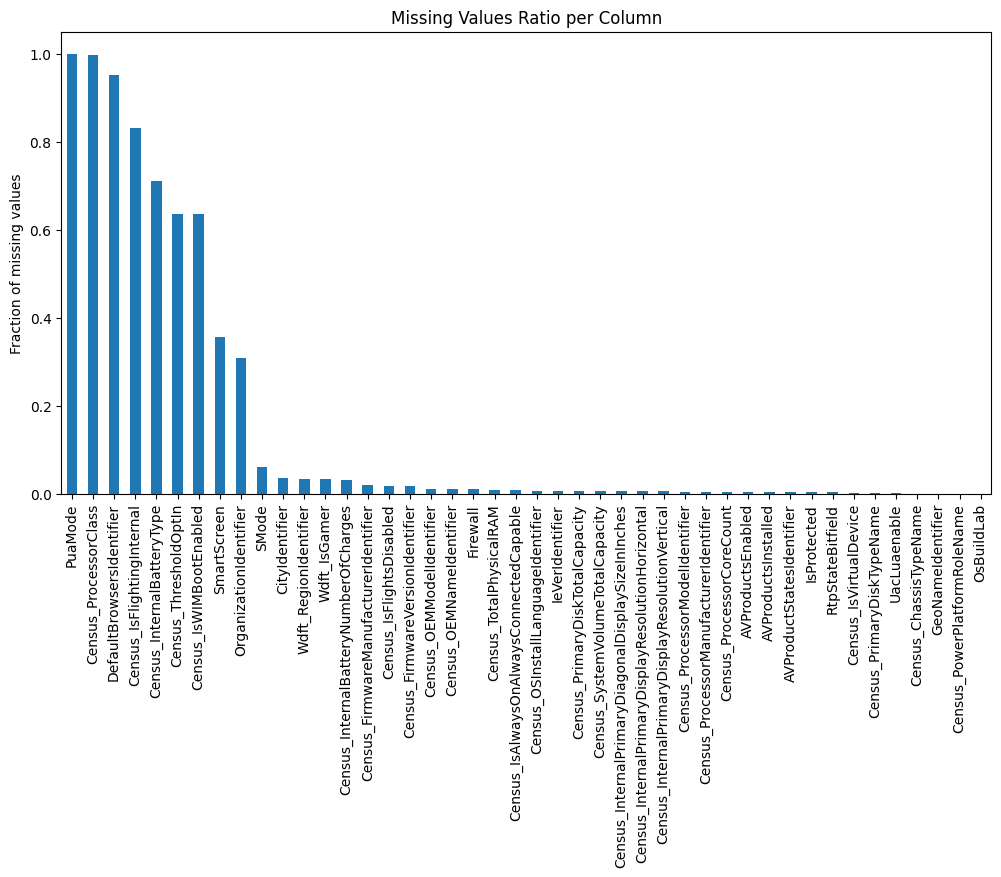

In [5]:
# 🔍 4. Missing Values
missing_train = df_train.isnull().sum() / df_train.shape[0]
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_train.plot(kind='bar')
plt.title('Missing Values Ratio per Column')
plt.ylabel('Fraction of missing values')
plt.show()

In [7]:
# 🧹 5. Simple Imputation
def simple_impute(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('missing')
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

# Apply to both train and test
df_train = simple_impute(df_train)
df_test = simple_impute(df_test)

In [8]:
# 🔠 6. Label Encoding for Categorical Features
categorical = [col for col in df_train.columns if df_train[col].dtype == 'object']
for col in categorical:
    le = LabelEncoder()
    le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
    df_train[col] = le.transform(list(df_train[col].astype(str).values))
    df_test[col] = le.transform(list(df_test[col].astype(str).values))


In [9]:
# ⚙️ 7. Feature Selection (drop identifier and target for training)
features = [col for col in df_train.columns if col not in ['MachineIdentifier', 'HasDetections']]
X = df_train[features]
y = df_train['HasDetections']
X_test = df_test[features]

In [14]:
# 🤖 5. Train LightGBM with Stratified K-Fold
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(len(df_test))
oof = np.zeros(len(df_train))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold_ + 1}")
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    clf = lgb.train(params, trn_data, 300, valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(100)])
    oof[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print(f"CV AUC Score: {roc_auc_score(y, oof)}")

Fold 1
Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc: 0.714085
[200]	valid_0's auc: 0.721462
[300]	valid_0's auc: 0.725097
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.725097
Fold 2
Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc: 0.713768
[200]	valid_0's auc: 0.721172
[300]	valid_0's auc: 0.724845
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.724845
Fold 3
Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc: 0.714328
[200]	valid_0's auc: 0.721638
[300]	valid_0's auc: 0.725258
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.725258
Fold 4
Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc: 0.714137
[200]	valid_0's auc: 0.721314
[300]	valid_0's auc: 0.724852
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.724852
Fold 5
Training until validation scores don't improve fo

In [40]:
predictions

array([0.56143955, 0.61828801, 0.48349131, ..., 0.33752635, 0.47879906,
       0.3562142 ])

In [38]:
# 📁 9. Create Submission
df_sample['HasDetections'] = predictions
submission_path = "submission.csv"
df_sample.to_csv(submission_path, index=False)
print("Submission file created at:", submission_path)

Submission file created at: submission.csv
